In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data handling and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Feature selection and engineering
from sklearn.feature_selection import SelectKBest, f_classif

# Machine Learning Algorithms
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Evaluation
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_recall_fscore_support,
    roc_curve, 
    auc
)

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

# Logging and Warnings
import logging
import warnings
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)

In [11]:
class EmotionPredictor:
    def __init__(self, data_path):
        """
        Initialize the Emotion Prediction Model
        
        Parameters:
        - data_path: Path to the CSV file containing emotion data
        """
        # Logging configuration
        self.logger = logging.getLogger(__name__)
        
        # Load data from CSV
        self.data = pd.read_excel(data_path)
        
        # Preprocessing method called at the end of initialization
        self.preprocessing()
        
    def preprocessing(self):
        """
        Comprehensive data preprocessing
        """
        # Encode target variable
        self.label_encoder = LabelEncoder()
        self.data['Emotion_Encoded'] = self.label_encoder.fit_transform(self.data['Emotional State'])
        
        # Separate features and target
        self.X = self.data.drop(['Emotional State', 'Emotion_Encoded'], axis=1)
        self.y = self.data['Emotion_Encoded']
        
        # Adjust test size based on the number of samples
        test_size = max(0.2, 1 / len(np.unique(self.y)))
        
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=42, stratify=self.y
        )
        
        # Preprocessing pipeline
        numeric_features = self.X.columns
        
        # Preprocessing for numerical columns
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features)
            ])
        
    def create_advanced_models(self):
        """
        Create advanced machine learning models
        """
        # Base models
        self.base_models = [
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('svm', SVC(probability=True, kernel='rbf')),
            ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1)),
            ('lgbm', LGBMClassifier(n_estimators=100)),
            ('mlp', MLPClassifier(max_iter=1000, random_state=42))
        ]
        
        # Stacking Classifier
        self.stacking_classifier = StackingClassifier(
            estimators=self.base_models,
            final_estimator=GradientBoostingClassifier(),
            cv=5
        )
        
    def train_and_evaluate(self):
        """
        Train models and evaluate performance
        """
        # Create preprocessing and model pipeline
        pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('feature_selection', SelectKBest(f_classif, k=min(5, self.X.shape[1]))),
            ('classifier', self.stacking_classifier)
        ])
        
        # Train the model
        pipeline.fit(self.X_train, self.y_train)
        
        # Predictions
        y_pred = pipeline.predict(self.X_test)
        y_pred_proba = pipeline.predict_proba(self.X_test)
        
        # Evaluation metrics
        print("Classification Report:")
        print(classification_report(
            self.y_test, 
            y_pred, 
            target_names=self.label_encoder.classes_
        ))
        
        # Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', 
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()
        
        # ROC Curve
        self.plot_roc_curve(y_pred_proba)
        
    def plot_roc_curve(self, y_pred_proba):
        """
        Plot ROC Curve for multi-class classification
        """
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(len(self.label_encoder.classes_)):
            fpr[i], tpr[i], _ = roc_curve(
                (self.y_test == i).ravel(), 
                y_pred_proba[:, i]
            )
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        plt.figure(figsize=(10, 8))
        for i in range(len(self.label_encoder.classes_)):
            plt.plot(fpr[i], tpr[i], 
                     label=f'ROC curve (class: {self.label_encoder.classes_[i]}, area = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        
    def hyperparameter_tuning(self):
        """
        Advanced hyperparameter tuning using RandomizedSearchCV
        """
        # Create preprocessing and model pipeline
        pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('feature_selection', SelectKBest(f_classif, k=min(5, self.X.shape[1]))),
            ('classifier', self.stacking_classifier)
        ])
        
        param_distributions = {
            'preprocessor__num__imputer__strategy': ['mean', 'median'],
            'feature_selection__k': list(range(1, min(6, self.X.shape[1] + 1))),
            'classifier__rf__n_estimators': randint(50, 200),
            'classifier__rf__max_depth': [None, 10, 20, 30],
            'classifier__svm__C': uniform(0.1, 10),
            'classifier__svm__gamma': ['scale', 'auto'] + list(uniform(0.1, 1).rvs(3)),
            'classifier__xgb__learning_rate': uniform(0.01, 0.3),
            'classifier__mlp__hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)]
        }
        
        # Create the RandomizedSearchCV object
        random_search = RandomizedSearchCV(
            estimator=pipeline, 
            param_distributions=param_distributions,
            n_iter=100, 
            cv=StratifiedKFold(n_splits=5),
            scoring='f1_weighted',
            random_state=42
        )
        
        random_search.fit(self.X_train, self.y_train)
        
        print("Best parameters:", random_search.best_params_)
        print("Best cross-validation score:", random_search.best_score_)

In [12]:
emotion_predictor = EmotionPredictor('vital_signs_emotions.xlsx')

In [13]:
emotion_predictor

In [14]:
emotion_predictor.create_advanced_models()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1032
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 5
[LightGBM] [Info] Start training from score -1.798407
[LightGBM] [Info] Start training from score -1.776009
[LightGBM] [Info] Start training from score -1.803706
[LightGBM] [Info] Start training from score -1.801053
[LightGBM] [Info] Start training from score -1.783419
[LightGBM] [Info] Start training from score -1.788266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1032
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 5
[LightGBM] [Info] Start training from score -1.798029
[LightGBM] [Info] Start training from score -1

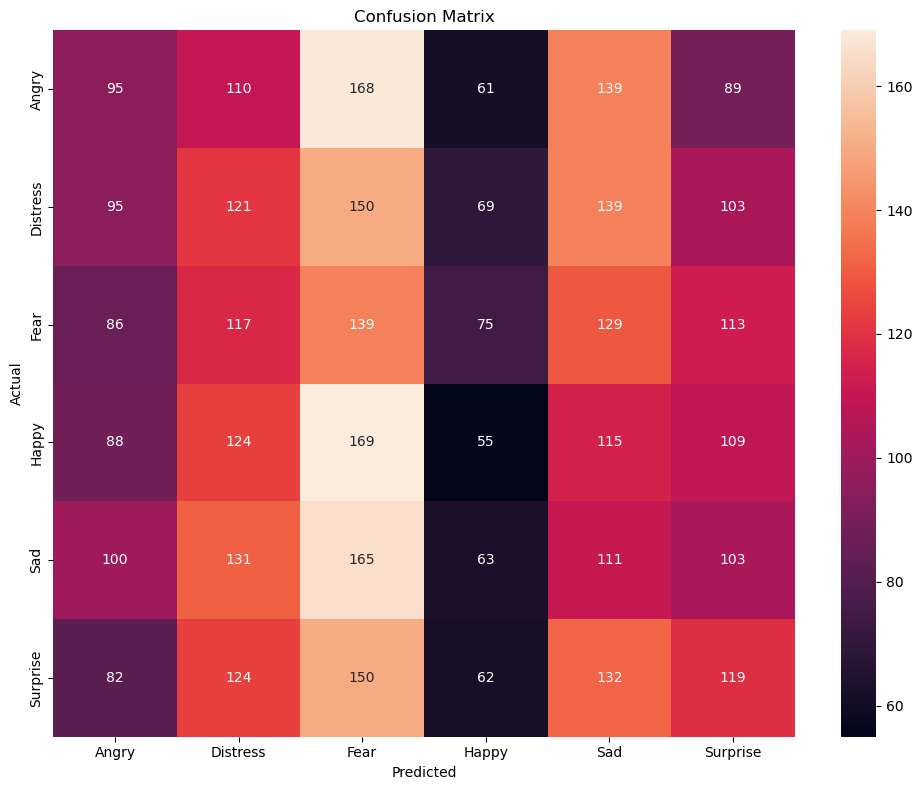

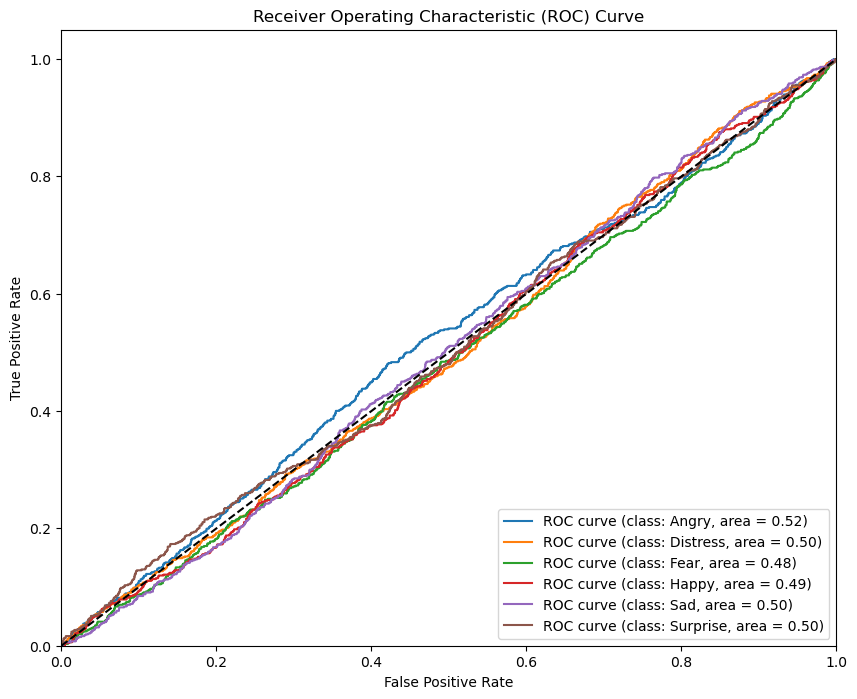

In [16]:
emotion_predictor.train_and_evaluate()

In [ ]:
 emotion_predictor.hyperparameter_tuning()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 2
[LightGBM] [Info] Start training from score -1.798029
[LightGBM] [Info] Start training from score -1.776101
[LightGBM] [Info] Start training from score -1.803706
[LightGBM] [Info] Start training from score -1.801336
[LightGBM] [Info] Start training from score -1.783512
[LightGBM] [Info] Start training from score -1.788172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10240, number of used features: 2
[LightGBM] [Info] Start training from 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10240, number of used features: 2
[LightGBM] [Info] Start training from score -1.798619
[LightGBM] [Info] Start training from score -1.776448
[LightGBM] [Info] Start training from score -1.803350
[LightGBM] [Info] Start training from score -1.800982
[LightGBM] [Info] Start training from score -1.782815
[LightGBM] [Info] Start training from score -1.788639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10240, number of used features: 2
[LightGBM] [Info] Start training from score -1.798029
[LightGBM] [Info] Start training from score -1.7

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 10240, number of used features: 2
[LightGBM] [Info] Start training from score -1.798619
[LightGBM] [Info] Start training from score -1.775871
[LightGBM] [Info] Start training from score -1.803943
[LightGBM] [Info] Start training from score -1.800982
[LightGBM] [Info] Start training from score -1.783396
[LightGBM] [Info] Start training from score -1.788055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 10240, number of used features: 2
[LightGBM] [Info] Start training from score -1.798619
[LightGBM] [Info] Start training from score -1.7